In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 787.60it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:18<00:00, 14.92img/s]

***
Unet Loss: 0.37818628549575806     Segnet Loss: 0.6805641055107117     Enet Loss: 1.0717358589172363
Voting Loss: 0.710162083307902


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.11img/s]

---
Unet Validation Dice Score: 0.4892137944698334     Segnet Validation Dice Score: 0.03749576210975647     Enet Validation Dice Score: 0.19483999907970428
---
Ensemble Voting Validation Dice Loss: 0.945310115814209
Ensemble Voting Validation Pixel Accuracy: 0.8587611683628016 
Ensemble Voting Validation MIoU: 0.4930131837820453
Ensemble Voting Validation Dice Score: 0.27916812896728516 



Epoch 2/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.87img/s]

***
Unet Loss: 0.31856125593185425     Segnet Loss: 0.4491935968399048     Enet Loss: 0.9904459118843079
Voting Loss: 0.5860669215520223


Epoch 2/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.65img/s]

---
Unet Validation Dice Score: 0.7179229855537415     Segnet Validation Dice Score: 0.6899496912956238     Enet Validation Dice Score: 0.27052566409111023
---
Ensemble Voting Validation Dice Loss: 0.6908583641052246
Ensemble Voting Validation Pixel Accuracy: 0.916164197419819 
Ensemble Voting Validation MIoU: 0.7578146868445521
Ensemble Voting Validation Dice Score: 0.7435643076896667 



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.2504093050956726     Segnet Loss: 0.3089843690395355     Enet Loss: 0.8579037189483643
Voting Loss: 0.4724324643611908


Epoch 3/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]

---
Unet Validation Dice Score: 0.8417189717292786     Segnet Validation Dice Score: 0.7057092785835266     Enet Validation Dice Score: 0.354224294424057
---
Ensemble Voting Validation Dice Loss: 0.5106196403503418
Ensemble Voting Validation Pixel Accuracy: 0.9368644848204496 
Ensemble Voting Validation MIoU: 0.7928578587868873
Ensemble Voting Validation Dice Score: 0.7882213592529297 



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.2599067687988281     Segnet Loss: 0.25662627816200256     Enet Loss: 0.7822532653808594
Voting Loss: 0.43292877078056335


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.22img/s]

---
Unet Validation Dice Score: 0.8467105031013489     Segnet Validation Dice Score: 0.7828628420829773     Enet Validation Dice Score: 0.3956030309200287
---
Ensemble Voting Validation Dice Loss: 0.5306209723154703
Ensemble Voting Validation Pixel Accuracy: 0.9243549547697368 
Ensemble Voting Validation MIoU: 0.7691282184831967
Ensemble Voting Validation Dice Score: 0.8459417223930359 



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.2775287926197052     Segnet Loss: 0.2916276454925537     Enet Loss: 0.7293223142623901
Voting Loss: 0.4328262507915497


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
Unet Validation Dice Score: 0.8699058890342712     Segnet Validation Dice Score: 0.8183168768882751     Enet Validation Dice Score: 0.4459342062473297
---
Ensemble Voting Validation Dice Loss: 0.4364035924275716
Ensemble Voting Validation Pixel Accuracy: 0.946441650390625 
Ensemble Voting Validation MIoU: 0.8264306938189554
Ensemble Voting Validation Dice Score: 0.8507343530654907 



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.18173786997795105     Segnet Loss: 0.1687288135290146     Enet Loss: 0.6477915048599243
Voting Loss: 0.33275272945563


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.8537306189537048     Segnet Validation Dice Score: 0.8407407999038696     Enet Validation Dice Score: 0.49228984117507935
---
Ensemble Voting Validation Dice Loss: 0.41966843605041504
Ensemble Voting Validation Pixel Accuracy: 0.9426759418688322 
Ensemble Voting Validation MIoU: 0.816665732197214
Ensemble Voting Validation Dice Score: 0.8631256222724915 



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.69img/s]

***
Unet Loss: 0.1860765516757965     Segnet Loss: 0.20395463705062866     Enet Loss: 0.5844480991363525
Voting Loss: 0.3248264292875926


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
Unet Validation Dice Score: 0.8735065460205078     Segnet Validation Dice Score: 0.8515545129776001     Enet Validation Dice Score: 0.5234914422035217
---
Ensemble Voting Validation Dice Loss: 0.371282418568929
Ensemble Voting Validation Pixel Accuracy: 0.9480853164405153 
Ensemble Voting Validation MIoU: 0.8264633631670597
Ensemble Voting Validation Dice Score: 0.8749837875366211 



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.17173385620117188     Segnet Loss: 0.13186071813106537     Enet Loss: 0.561200737953186
Voting Loss: 0.2882651040951411


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
Unet Validation Dice Score: 0.8784331679344177     Segnet Validation Dice Score: 0.8662249445915222     Enet Validation Dice Score: 0.5468770861625671
---
Ensemble Voting Validation Dice Loss: 0.35642186800638836
Ensemble Voting Validation Pixel Accuracy: 0.9453572055749726 
Ensemble Voting Validation MIoU: 0.822690987639757
Ensemble Voting Validation Dice Score: 0.8777031898498535 



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.72img/s]

***
Unet Loss: 0.15338701009750366     Segnet Loss: 0.11105405539274216     Enet Loss: 0.5082371234893799
Voting Loss: 0.2575593963265419


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.8440017104148865     Segnet Validation Dice Score: 0.8666560053825378     Enet Validation Dice Score: 0.5738579630851746
---
Ensemble Voting Validation Dice Loss: 0.3230193654696147
Ensemble Voting Validation Pixel Accuracy: 0.9507639031661185 
Ensemble Voting Validation MIoU: 0.8336205646613177
Ensemble Voting Validation Dice Score: 0.8706055879592896 



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.14389488101005554     Segnet Loss: 0.1329418420791626     Enet Loss: 0.49505677819252014
Voting Loss: 0.2572978337605794


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.44img/s]

---
Unet Validation Dice Score: 0.8168998956680298     Segnet Validation Dice Score: 0.8726657032966614     Enet Validation Dice Score: 0.5896154642105103
---
Ensemble Voting Validation Dice Loss: 0.3546517292658488
Ensemble Voting Validation Pixel Accuracy: 0.944000244140625 
Ensemble Voting Validation MIoU: 0.8257857701445449
Ensemble Voting Validation Dice Score: 0.866080105304718 



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.14092808961868286     Segnet Loss: 0.10874921083450317     Enet Loss: 0.46153175830841064
Voting Loss: 0.23706968625386557


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
Unet Validation Dice Score: 0.8742241859436035     Segnet Validation Dice Score: 0.8833625912666321     Enet Validation Dice Score: 0.6168721914291382
---
Ensemble Voting Validation Dice Loss: 0.29489274819691974
Ensemble Voting Validation Pixel Accuracy: 0.9531753272341009 
Ensemble Voting Validation MIoU: 0.847133825201838
Ensemble Voting Validation Dice Score: 0.8834999203681946 



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
Unet Loss: 0.10956200957298279     Segnet Loss: 0.080081045627594     Enet Loss: 0.4029269218444824
Voting Loss: 0.1975233256816864


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.44img/s]

---
Unet Validation Dice Score: 0.901947021484375     Segnet Validation Dice Score: 0.8784899115562439     Enet Validation Dice Score: 0.657073974609375
---
Ensemble Voting Validation Dice Loss: 0.273112416267395
Ensemble Voting Validation Pixel Accuracy: 0.9556592974746436 
Ensemble Voting Validation MIoU: 0.8530490455614796
Ensemble Voting Validation Dice Score: 0.8960490226745605 



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.10526877641677856     Segnet Loss: 0.06509511172771454     Enet Loss: 0.40173807740211487
Voting Loss: 0.19070065518220267


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]

---
Unet Validation Dice Score: 0.9018718004226685     Segnet Validation Dice Score: 0.9034203886985779     Enet Validation Dice Score: 0.7173172235488892
---
Ensemble Voting Validation Dice Loss: 0.25366894404093426
Ensemble Voting Validation Pixel Accuracy: 0.961492705763432 
Ensemble Voting Validation MIoU: 0.8675451521492511
Ensemble Voting Validation Dice Score: 0.9101871848106384 



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.12749631702899933     Segnet Loss: 0.1446669101715088     Enet Loss: 0.415101557970047
Voting Loss: 0.22908826172351837


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]

---
Unet Validation Dice Score: 0.9023136496543884     Segnet Validation Dice Score: 0.8862956166267395     Enet Validation Dice Score: 0.7569133043289185
---
Ensemble Voting Validation Dice Loss: 0.24411980311075845
Ensemble Voting Validation Pixel Accuracy: 0.9626060619688871 
Ensemble Voting Validation MIoU: 0.8728201457763649
Ensemble Voting Validation Dice Score: 0.8987385630607605 



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.10525091737508774     Segnet Loss: 0.07800174504518509     Enet Loss: 0.38191595673561096
Voting Loss: 0.18838953971862793


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
Unet Validation Dice Score: 0.8996745944023132     Segnet Validation Dice Score: 0.899296224117279     Enet Validation Dice Score: 0.7876140475273132
---
Ensemble Voting Validation Dice Loss: 0.236099640528361
Ensemble Voting Validation Pixel Accuracy: 0.9642342015316612 
Ensemble Voting Validation MIoU: 0.876951149177235
Ensemble Voting Validation Dice Score: 0.9048464894294739 



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.10037992149591446     Segnet Loss: 0.0688672661781311     Enet Loss: 0.338206946849823
Voting Loss: 0.16915137817462286


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9064472317695618     Segnet Validation Dice Score: 0.8935334086418152     Enet Validation Dice Score: 0.8073232769966125
---
Ensemble Voting Validation Dice Loss: 0.23007404804229736
Ensemble Voting Validation Pixel Accuracy: 0.9644413998252467 
Ensemble Voting Validation MIoU: 0.8768553809978972
Ensemble Voting Validation Dice Score: 0.9085506796836853 



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.0967160016298294     Segnet Loss: 0.04858549311757088     Enet Loss: 0.31193381547927856
Voting Loss: 0.15241177007555962


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]

---
Unet Validation Dice Score: 0.9045774340629578     Segnet Validation Dice Score: 0.9132936596870422     Enet Validation Dice Score: 0.8282753825187683
---
Ensemble Voting Validation Dice Loss: 0.2199257810910543
Ensemble Voting Validation Pixel Accuracy: 0.9676229911938048 
Ensemble Voting Validation MIoU: 0.8868342300709735
Ensemble Voting Validation Dice Score: 0.9166345596313477 



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.09463538974523544     Segnet Loss: 0.05453458055853844     Enet Loss: 0.32750940322875977
Voting Loss: 0.15889312451084456


Epoch 18/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
Unet Validation Dice Score: 0.9073511958122253     Segnet Validation Dice Score: 0.9099523425102234     Enet Validation Dice Score: 0.8366180658340454
---
Ensemble Voting Validation Dice Loss: 0.20956615606943765
Ensemble Voting Validation Pixel Accuracy: 0.9697284363863761 
Ensemble Voting Validation MIoU: 0.892234878580122
Ensemble Voting Validation Dice Score: 0.915090024471283 



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.09621547907590866     Segnet Loss: 0.04559137299656868     Enet Loss: 0.30638009309768677
Voting Loss: 0.1493956483900547


Epoch 19/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.54img/s]

---
Unet Validation Dice Score: 0.8958490490913391     Segnet Validation Dice Score: 0.9111833572387695     Enet Validation Dice Score: 0.8471827507019043
---
Ensemble Voting Validation Dice Loss: 0.21212522188822427
Ensemble Voting Validation Pixel Accuracy: 0.9659316748903509 
Ensemble Voting Validation MIoU: 0.881430414278988
Ensemble Voting Validation Dice Score: 0.91117924451828 



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.09011722356081009     Segnet Loss: 0.0451795756816864     Enet Loss: 0.26174646615982056
Voting Loss: 0.13234775513410568


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
Unet Validation Dice Score: 0.9080830812454224     Segnet Validation Dice Score: 0.9124032258987427     Enet Validation Dice Score: 0.8471618890762329
---
Ensemble Voting Validation Dice Loss: 0.218153715133667
Ensemble Voting Validation Pixel Accuracy: 0.9634169193736294 
Ensemble Voting Validation MIoU: 0.8745659769199863
Ensemble Voting Validation Dice Score: 0.9161712527275085 



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.09397298842668533     Segnet Loss: 0.04040251672267914     Enet Loss: 0.2767416834831238
Voting Loss: 0.1370390628774961


Epoch 21/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]

---
Unet Validation Dice Score: 0.9026281237602234     Segnet Validation Dice Score: 0.9169701933860779     Enet Validation Dice Score: 0.8531064987182617
---
Ensemble Voting Validation Dice Loss: 0.21114798386891684
Ensemble Voting Validation Pixel Accuracy: 0.9658714428282621 
Ensemble Voting Validation MIoU: 0.8826012681202318
Ensemble Voting Validation Dice Score: 0.9184900522232056 



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.77img/s]

***
Unet Loss: 0.10888887196779251     Segnet Loss: 0.04376913979649544     Enet Loss: 0.2415844351053238
Voting Loss: 0.13141414895653725


Epoch 22/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.11img/s]

---
Unet Validation Dice Score: 0.9062420725822449     Segnet Validation Dice Score: 0.9145038723945618     Enet Validation Dice Score: 0.8467389345169067
---
Ensemble Voting Validation Dice Loss: 0.20603346824645996
Ensemble Voting Validation Pixel Accuracy: 0.9657665051912007 
Ensemble Voting Validation MIoU: 0.8820139782465888
Ensemble Voting Validation Dice Score: 0.9183112978935242 



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.10810162127017975     Segnet Loss: 0.05085111781954765     Enet Loss: 0.2875458002090454
Voting Loss: 0.14883284643292427


Epoch 23/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]

---
Unet Validation Dice Score: 0.9014131426811218     Segnet Validation Dice Score: 0.9129776358604431     Enet Validation Dice Score: 0.8584688305854797
---
Ensemble Voting Validation Dice Loss: 0.21401248375574747
Ensemble Voting Validation Pixel Accuracy: 0.9611072205660636 
Ensemble Voting Validation MIoU: 0.8690385090248103
Ensemble Voting Validation Dice Score: 0.9125649333000183 



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.09094376862049103     Segnet Loss: 0.04832752048969269     Enet Loss: 0.24681438505649567
Voting Loss: 0.12869522472222647


Epoch 24/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.9059160351753235     Segnet Validation Dice Score: 0.9176607131958008     Enet Validation Dice Score: 0.8539552688598633
---
Ensemble Voting Validation Dice Loss: 0.19836131731669107
Ensemble Voting Validation Pixel Accuracy: 0.9665259645696271 
Ensemble Voting Validation MIoU: 0.8841577759704731
Ensemble Voting Validation Dice Score: 0.9174118041992188 



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
Unet Loss: 0.10418841242790222     Segnet Loss: 0.05257124826312065     Enet Loss: 0.2689718008041382
Voting Loss: 0.1419104871650537


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.47img/s]

---
Unet Validation Dice Score: 0.9088732600212097     Segnet Validation Dice Score: 0.9112289547920227     Enet Validation Dice Score: 0.8631128668785095
---
Ensemble Voting Validation Dice Loss: 0.20446987946828207
Ensemble Voting Validation Pixel Accuracy: 0.9626566569010416 
Ensemble Voting Validation MIoU: 0.873356065442596
Ensemble Voting Validation Dice Score: 0.914502739906311 



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.22img/s]

***
Unet Loss: 0.09152443706989288     Segnet Loss: 0.04409458488225937     Enet Loss: 0.24060627818107605
Voting Loss: 0.12540843337774277


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
Unet Validation Dice Score: 0.9078956842422485     Segnet Validation Dice Score: 0.9130819439888     Enet Validation Dice Score: 0.8612882494926453
---
Ensemble Voting Validation Dice Loss: 0.19968819618225098
Ensemble Voting Validation Pixel Accuracy: 0.9638479132401315 
Ensemble Voting Validation MIoU: 0.8767527640237278
Ensemble Voting Validation Dice Score: 0.9154049158096313 



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.42img/s]

***
Unet Loss: 0.09284676611423492     Segnet Loss: 0.047787267714738846     Enet Loss: 0.27267003059387207
Voting Loss: 0.13776802147428194


Epoch 27/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.9073924422264099     Segnet Validation Dice Score: 0.9134699702262878     Enet Validation Dice Score: 0.8681280016899109
---
Ensemble Voting Validation Dice Loss: 0.19960463047027588
Ensemble Voting Validation Pixel Accuracy: 0.9635547838712993 
Ensemble Voting Validation MIoU: 0.8761312894256428
Ensemble Voting Validation Dice Score: 0.9162780046463013 



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.08805468678474426     Segnet Loss: 0.04654408618807793     Enet Loss: 0.20838752388954163
Voting Loss: 0.11432876562078793


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
Unet Validation Dice Score: 0.9090642333030701     Segnet Validation Dice Score: 0.9182766079902649     Enet Validation Dice Score: 0.8651247024536133
---
Ensemble Voting Validation Dice Loss: 0.1891141732533773
Ensemble Voting Validation Pixel Accuracy: 0.9676524379797149 
Ensemble Voting Validation MIoU: 0.8862024160841733
Ensemble Voting Validation Dice Score: 0.9190981984138489 



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.09226459264755249     Segnet Loss: 0.04667191207408905     Enet Loss: 0.2506107985973358
Voting Loss: 0.12984910110632578


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.27img/s]

---
Unet Validation Dice Score: 0.9083690047264099     Segnet Validation Dice Score: 0.9127832651138306     Enet Validation Dice Score: 0.8605319857597351
---
Ensemble Voting Validation Dice Loss: 0.19631932179133096
Ensemble Voting Validation Pixel Accuracy: 0.966701306794819 
Ensemble Voting Validation MIoU: 0.8845027291342258
Ensemble Voting Validation Dice Score: 0.9165608286857605 



Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.08233252167701721     Segnet Loss: 0.037389956414699554     Enet Loss: 0.18642643094062805
Voting Loss: 0.10204963634411494


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
Unet Validation Dice Score: 0.9093177914619446     Segnet Validation Dice Score: 0.9131456613540649     Enet Validation Dice Score: 0.8709412813186646
---
Ensemble Voting Validation Dice Loss: 0.19848787784576416
Ensemble Voting Validation Pixel Accuracy: 0.9635111490885416 
Ensemble Voting Validation MIoU: 0.8756306517165635
Ensemble Voting Validation Dice Score: 0.9158444404602051 



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.09557900577783585     Segnet Loss: 0.04962046444416046     Enet Loss: 0.25155121088027954
Voting Loss: 0.13225022703409195


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9100770354270935     Segnet Validation Dice Score: 0.9127556681632996     Enet Validation Dice Score: 0.8770110011100769
---
Ensemble Voting Validation Dice Loss: 0.19861549139022827
Ensemble Voting Validation Pixel Accuracy: 0.962236906352796 
Ensemble Voting Validation MIoU: 0.8710764656177938
Ensemble Voting Validation Dice Score: 0.9170966148376465 



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
Unet Loss: 0.09627312421798706     Segnet Loss: 0.05933746322989464     Enet Loss: 0.24384266138076782
Voting Loss: 0.13315108294288316


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
Unet Validation Dice Score: 0.9100845456123352     Segnet Validation Dice Score: 0.9172620177268982     Enet Validation Dice Score: 0.8714408278465271
---
Ensemble Voting Validation Dice Loss: 0.18121439218521118
Ensemble Voting Validation Pixel Accuracy: 0.9676883095189145 
Ensemble Voting Validation MIoU: 0.8848532408228559
Ensemble Voting Validation Dice Score: 0.9188749194145203 



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.08454775810241699     Segnet Loss: 0.041685014963150024     Enet Loss: 0.23050056397914886
Voting Loss: 0.11891111234823863


Epoch 33/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]

---
Unet Validation Dice Score: 0.9064200520515442     Segnet Validation Dice Score: 0.9179462790489197     Enet Validation Dice Score: 0.8631700873374939
---
Ensemble Voting Validation Dice Loss: 0.18041356404622397
Ensemble Voting Validation Pixel Accuracy: 0.968418322111431 
Ensemble Voting Validation MIoU: 0.8878806039679294
Ensemble Voting Validation Dice Score: 0.9175095558166504 



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.08511707186698914     Segnet Loss: 0.040493592619895935     Enet Loss: 0.27551883459091187
Voting Loss: 0.1337098330259323


Epoch 34/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
Unet Validation Dice Score: 0.9058143496513367     Segnet Validation Dice Score: 0.9164137840270996     Enet Validation Dice Score: 0.873969554901123
---
Ensemble Voting Validation Dice Loss: 0.1814399560292562
Ensemble Voting Validation Pixel Accuracy: 0.9661233466968202 
Ensemble Voting Validation MIoU: 0.8813016245159224
Ensemble Voting Validation Dice Score: 0.9175214767456055 



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
Unet Loss: 0.1038038581609726     Segnet Loss: 0.06086869537830353     Enet Loss: 0.21967476606369019
Voting Loss: 0.12811577320098877


Epoch 35/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]

---
Unet Validation Dice Score: 0.9074113965034485     Segnet Validation Dice Score: 0.9123525619506836     Enet Validation Dice Score: 0.8782930374145508
---
Ensemble Voting Validation Dice Loss: 0.1907368302345276
Ensemble Voting Validation Pixel Accuracy: 0.9630614163582785 
Ensemble Voting Validation MIoU: 0.8732200991249277
Ensemble Voting Validation Dice Score: 0.9165975451469421 



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.47img/s]

***
Unet Loss: 0.09327184408903122     Segnet Loss: 0.046718038618564606     Enet Loss: 0.1916053593158722
Voting Loss: 0.110531747341156


Epoch 36/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.9075384140014648     Segnet Validation Dice Score: 0.9164494872093201     Enet Validation Dice Score: 0.877828061580658
---
Ensemble Voting Validation Dice Loss: 0.1854704221089681
Ensemble Voting Validation Pixel Accuracy: 0.9639483000102796 
Ensemble Voting Validation MIoU: 0.8751362470448629
Ensemble Voting Validation Dice Score: 0.9187697768211365 



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.08593948930501938     Segnet Loss: 0.046619534492492676     Enet Loss: 0.20201541483402252
Voting Loss: 0.11152481287717819


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
Unet Validation Dice Score: 0.9094414710998535     Segnet Validation Dice Score: 0.9183560609817505     Enet Validation Dice Score: 0.8774387240409851
---
Ensemble Voting Validation Dice Loss: 0.18449262777964273
Ensemble Voting Validation Pixel Accuracy: 0.9642981813665021 
Ensemble Voting Validation MIoU: 0.87557906906206
Ensemble Voting Validation Dice Score: 0.9197496771812439 



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.84img/s]

***
Unet Loss: 0.09699857234954834     Segnet Loss: 0.05577029287815094     Enet Loss: 0.2172117680311203
Voting Loss: 0.12332687775293986


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.9079770445823669     Segnet Validation Dice Score: 0.9181979298591614     Enet Validation Dice Score: 0.8770154118537903
---
Ensemble Voting Validation Dice Loss: 0.17979395389556885
Ensemble Voting Validation Pixel Accuracy: 0.9661051432291666 
Ensemble Voting Validation MIoU: 0.8816154072707698
Ensemble Voting Validation Dice Score: 0.9191117286682129 



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.08400847017765045     Segnet Loss: 0.03855251148343086     Enet Loss: 0.15964043140411377
Voting Loss: 0.09406713768839836


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
Unet Validation Dice Score: 0.9077648520469666     Segnet Validation Dice Score: 0.9127506613731384     Enet Validation Dice Score: 0.8788277506828308
---
Ensemble Voting Validation Dice Loss: 0.1886147459348043
Ensemble Voting Validation Pixel Accuracy: 0.9634849146792763 
Ensemble Voting Validation MIoU: 0.8750095889687595
Ensemble Voting Validation Dice Score: 0.9162088632583618 



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.08987222611904144     Segnet Loss: 0.04210841655731201     Enet Loss: 0.16319477558135986
Voting Loss: 0.09839180608590443


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
Unet Validation Dice Score: 0.9079114198684692     Segnet Validation Dice Score: 0.914595901966095     Enet Validation Dice Score: 0.8800703287124634
---
Ensemble Voting Validation Dice Loss: 0.1937456727027893
Ensemble Voting Validation Pixel Accuracy: 0.9622366386547423 
Ensemble Voting Validation MIoU: 0.8710383766696279
Ensemble Voting Validation Dice Score: 0.9176740050315857 



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.09094521403312683     Segnet Loss: 0.049668967723846436     Enet Loss: 0.19097451865673065
Voting Loss: 0.11052956680456798


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
Unet Validation Dice Score: 0.9075023531913757     Segnet Validation Dice Score: 0.9157794117927551     Enet Validation Dice Score: 0.8796701431274414
---
Ensemble Voting Validation Dice Loss: 0.18258996804555258
Ensemble Voting Validation Pixel Accuracy: 0.9646593060409814 
Ensemble Voting Validation MIoU: 0.8766916487755317
Ensemble Voting Validation Dice Score: 0.9186043739318848 



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.07864047586917877     Segnet Loss: 0.040349237620830536     Enet Loss: 0.18606173992156982
Voting Loss: 0.10168381780385971


Epoch 42/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
Unet Validation Dice Score: 0.9066421389579773     Segnet Validation Dice Score: 0.916904628276825     Enet Validation Dice Score: 0.8776848912239075
---
Ensemble Voting Validation Dice Loss: 0.18047241369883218
Ensemble Voting Validation Pixel Accuracy: 0.9663798014322916 
Ensemble Voting Validation MIoU: 0.8829092165800374
Ensemble Voting Validation Dice Score: 0.9182440042495728 



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.09702961146831512     Segnet Loss: 0.05091311037540436     Enet Loss: 0.19647212326526642
Voting Loss: 0.11480494836966197


Epoch 43/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.43img/s]

---
Unet Validation Dice Score: 0.9068013429641724     Segnet Validation Dice Score: 0.9175910353660583     Enet Validation Dice Score: 0.8782998323440552
---
Ensemble Voting Validation Dice Loss: 0.18022473653157553
Ensemble Voting Validation Pixel Accuracy: 0.9668281956722862 
Ensemble Voting Validation MIoU: 0.884477631186804
Ensemble Voting Validation Dice Score: 0.9191595315933228 



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.0909193754196167     Segnet Loss: 0.050233468413352966     Enet Loss: 0.18597909808158875
Voting Loss: 0.10904398063818614


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
Unet Validation Dice Score: 0.9085812568664551     Segnet Validation Dice Score: 0.917622983455658     Enet Validation Dice Score: 0.8786233067512512
---
Ensemble Voting Validation Dice Loss: 0.18060884873072305
Ensemble Voting Validation Pixel Accuracy: 0.9657060054310581 
Ensemble Voting Validation MIoU: 0.8804091288395566
Ensemble Voting Validation Dice Score: 0.919050395488739 



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.07779447734355927     Segnet Loss: 0.0370083823800087     Enet Loss: 0.17446574568748474
Voting Loss: 0.0964228684703509


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
Unet Validation Dice Score: 0.9086953401565552     Segnet Validation Dice Score: 0.9173009991645813     Enet Validation Dice Score: 0.8788272738456726
---
Ensemble Voting Validation Dice Loss: 0.18351183334986368
Ensemble Voting Validation Pixel Accuracy: 0.9653887832373903 
Ensemble Voting Validation MIoU: 0.8803013936328885
Ensemble Voting Validation Dice Score: 0.9190269708633423 



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
Unet Loss: 0.10038651525974274     Segnet Loss: 0.05494743213057518     Enet Loss: 0.17998099327087402
Voting Loss: 0.11177164688706398


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
Unet Validation Dice Score: 0.9072431921958923     Segnet Validation Dice Score: 0.9137881398200989     Enet Validation Dice Score: 0.8782610297203064
---
Ensemble Voting Validation Dice Loss: 0.18337432543436685
Ensemble Voting Validation Pixel Accuracy: 0.9648319712856359 
Ensemble Voting Validation MIoU: 0.8782311708059823
Ensemble Voting Validation Dice Score: 0.9168208241462708 



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.09367348253726959     Segnet Loss: 0.050994761288166046     Enet Loss: 0.18980450928211212
Voting Loss: 0.11149091770251592


Epoch 47/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]

---
Unet Validation Dice Score: 0.9088859558105469     Segnet Validation Dice Score: 0.9099942445755005     Enet Validation Dice Score: 0.8801628947257996
---
Ensemble Voting Validation Dice Loss: 0.19459205865859985
Ensemble Voting Validation Pixel Accuracy: 0.9609894334224233 
Ensemble Voting Validation MIoU: 0.8671390302364186
Ensemble Voting Validation Dice Score: 0.9151203036308289 



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.07840543985366821     Segnet Loss: 0.03807636350393295     Enet Loss: 0.14778950810432434
Voting Loss: 0.08809043715397517


Epoch 48/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
Unet Validation Dice Score: 0.9070619940757751     Segnet Validation Dice Score: 0.918644368648529     Enet Validation Dice Score: 0.8751100897789001
---
Ensemble Voting Validation Dice Loss: 0.17900260289510092
Ensemble Voting Validation Pixel Accuracy: 0.966692472759046 
Ensemble Voting Validation MIoU: 0.8829093140912833
Ensemble Voting Validation Dice Score: 0.919083297252655 



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.08661733567714691     Segnet Loss: 0.049758173525333405     Enet Loss: 0.218126118183136
Voting Loss: 0.11816720912853877


Epoch 49/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
Unet Validation Dice Score: 0.9069027304649353     Segnet Validation Dice Score: 0.9152847528457642     Enet Validation Dice Score: 0.8785412907600403
---
Ensemble Voting Validation Dice Loss: 0.18449890613555908
Ensemble Voting Validation Pixel Accuracy: 0.9652675160190516 
Ensemble Voting Validation MIoU: 0.8791916037263128
Ensemble Voting Validation Dice Score: 0.9180468916893005 



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.10068146884441376     Segnet Loss: 0.05523919686675072     Enet Loss: 0.21692053973674774
Voting Loss: 0.12428040181597073


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
Unet Validation Dice Score: 0.9079040884971619     Segnet Validation Dice Score: 0.9147486090660095     Enet Validation Dice Score: 0.8789602518081665
---
Ensemble Voting Validation Dice Loss: 0.18865915139516196
Ensemble Voting Validation Pixel Accuracy: 0.9639512446888706 
Ensemble Voting Validation MIoU: 0.8762856139636838
Ensemble Voting Validation Dice Score: 0.9180768132209778 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list4, val_losses, valScore_list4, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

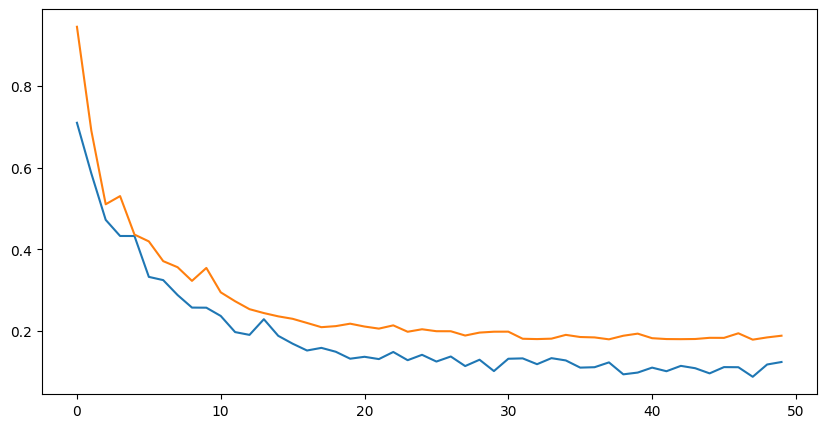

In [13]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list4)
plt.plot(val_losses)

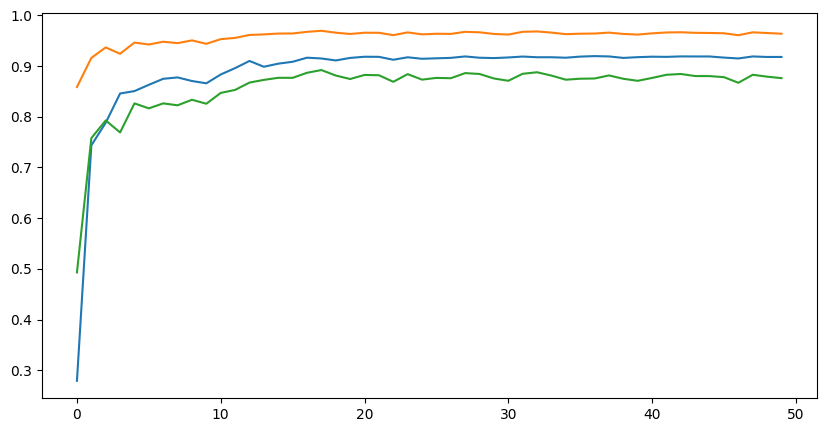

In [14]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list4)
plt.plot(val_accs)
plt.plot(val_mious)